In [57]:
import pandas as pd
import missingno as msno

from sklearn.preprocessing import MinMaxScaler

from google.cloud import bigquery
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
%config Completer.use_jedi = False  # for auto-completion

## Get dataset from BigQuery

In [7]:
PROJECT = "qwiklabs-gcp-04-151057592acb"  # change this

# Get query result and convert it to dataframe
query = """
        SELECT *
        FROM `qwiklabs-gcp-04-151057592acb.Joins.train_transaction_inner`;
		"""
bq = bigquery.Client(project=PROJECT)
card_fraud_dataset = bq.query(query).to_dataframe()
card_fraud_dataset.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3058086,0,1605804,150.0,R,6978,567.0,150.0,visa,195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3565638,0,15397195,150.0,R,6019,583.0,150.0,visa,226.0,...,4.0,1350.0,1350.0,1350.0,0.0,0.0,0.0,600.0,600.0,600.0
2,3546123,0,14823647,105.0,S,15775,481.0,150.0,mastercard,102.0,...,43.0,2900.0,49289.0,40960.0,265.0,2301.0,1052.0,1165.0,7709.0,4415.0
3,3548142,0,14859454,75.0,S,15775,481.0,150.0,mastercard,102.0,...,35.0,70813.0,117467.0,78551.0,0.0,2301.0,1052.0,1165.0,7709.0,3657.0
4,3546538,0,14830185,106.0,S,15775,481.0,150.0,mastercard,102.0,...,42.0,29920.0,76474.0,58715.0,100.0,2301.0,1052.0,1165.0,7709.0,4360.0


In [66]:
card_fraud_dataset.shape

(144233, 394)

## Basic EDA

Extent of class-imbalance in dataset

In [67]:
card_fraud_dataset.isFraud.value_counts(normalize=True)

0    0.92153
1    0.07847
Name: isFraud, dtype: float64

In [68]:
card_fraud_dataset.columns.to_list()[:25]

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8']

Pick only selected columns: based on feature importance from AutoML Tables (Google Cloud)

In [69]:
selected_columns = ['TransactionID',
                     'isFraud',
                     'TransactionDT',
                     'TransactionAmt',
                     'ProductCD',
                     'card1',
                     'card2',
                     'card3',
                     'card6',
                     'P_emaildomain',
                     'R_emaildomain',
                     'C1',
                     'C2',
                     'C11',
                     'C12',
                     'C13',
                     'C14',
                     'D8',
                     'V45',
                     'V87',
                     'V258']

len(selected_columns)

21

In [85]:
dataset_select_cols = card_fraud_dataset[selected_columns]

dataset_select_cols.shape

(144233, 21)

In [86]:
dataset_select_cols.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card6,P_emaildomain,...,C1,C2,C11,C12,C13,C14,D8,V45,V87,V258
0,3058086,0,1605804,150.0,R,6978,567.0,150.0,credit,cox.net,...,1037.0,1139.0,816.0,0.0,571.0,519.0,67.583336,NaN,NaN,NaN
1,3565638,0,15397195,150.0,R,6019,583.0,150.0,credit,gmail.com,...,4.0,3.0,2.0,0.0,1.0,1.0,1299.166626,NaN,NaN,NaN
2,3546123,0,14823647,105.0,S,15775,481.0,150.0,credit,None,...,5.0,3.0,5.0,0.0,61.0,5.0,26.541666,NaN,NaN,NaN
3,3548142,0,14859454,75.0,S,15775,481.0,150.0,credit,None,...,5.0,3.0,5.0,0.0,61.0,5.0,26.958332,NaN,NaN,NaN
4,3546538,0,14830185,106.0,S,15775,481.0,150.0,credit,None,...,5.0,3.0,5.0,0.0,61.0,5.0,26.625000,NaN,NaN,NaN


Check null values

In [87]:
dataset_select_cols.isna().mean() * 100  # percentage of missing values in each column

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              0.625377
card3              0.119251
card6              0.123411
P_emaildomain      9.284283
R_emaildomain      9.117192
C1                 0.000000
C2                 0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D8                48.052110
V45               55.110828
V87               52.669639
V258               9.681557
dtype: float64

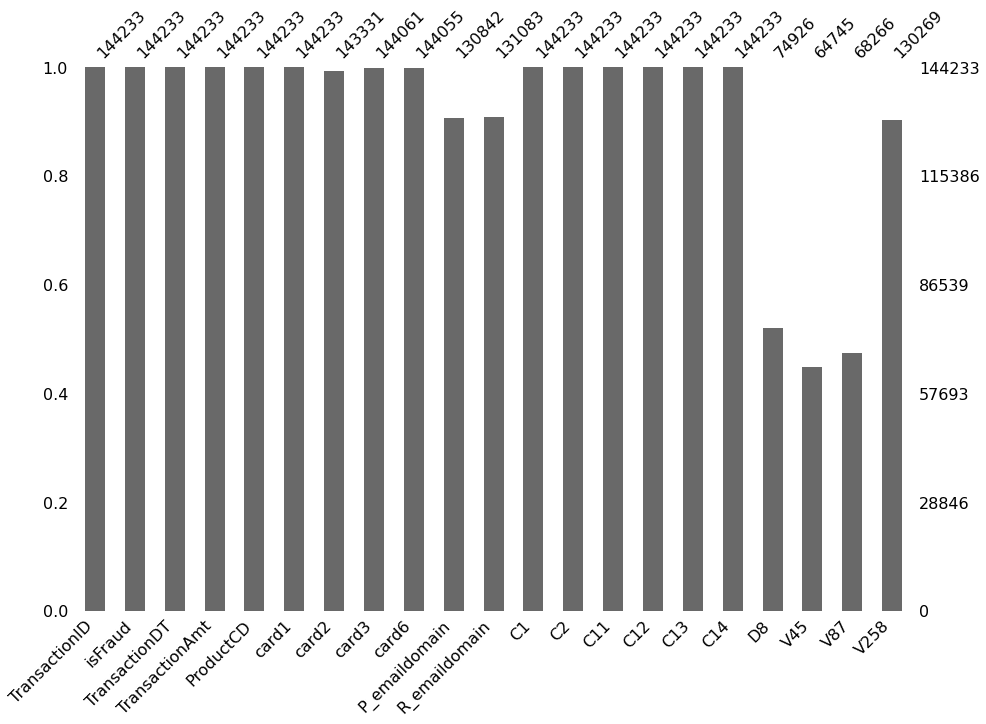

In [88]:
ax = msno.bar(dataset_select_cols,
              figsize=(15,10))
ax.get_figure().savefig("plots/missing_values.png")

Check dtypes

In [89]:
dataset_select_cols.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card6              object
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C11               float64
C12               float64
C13               float64
C14               float64
D8                float64
V45               float64
V87               float64
V258              float64
dtype: object

## Encoding of categorical columns

In [75]:
dataset_select_cols.shape

(144233, 21)

In [76]:
categorical_feature_columns = ['ProductCD', 'card6',
                               'P_emaildomain', 'R_emaildomain']

dataset_select_cols = pd.get_dummies(dataset_select_cols, 
                                     columns=categorical_feature_columns)

dataset_select_cols.shape

(144233, 143)

Note: It is not really a best practice to do do encoding at this stage of the ml pipeline. But more on that later.

## Train - Validation split

In [90]:
train_pct = 0.8  # first 80% rows in train set, last 20% in validation set

dataset_select_cols[:int(dataset_select_cols.shape[0] * train_pct)].shape[0] + \
dataset_select_cols[int(dataset_select_cols.shape[0] * train_pct):].shape[0] == \
dataset_select_cols.shape[0]

True

In [91]:
train_set = dataset_select_cols[:int(dataset_select_cols.shape[0] * train_pct)]
val_set = dataset_select_cols[int(dataset_select_cols.shape[0] * train_pct):]

Sanity-check: same number of columns?

In [92]:
train_set.shape[1] == val_set.shape[1]

True

In [93]:
train_set.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card6,P_emaildomain,...,C1,C2,C11,C12,C13,C14,D8,V45,V87,V258
0,3058086,0,1605804,150.0,R,6978,567.0,150.0,credit,cox.net,...,1037.0,1139.0,816.0,0.0,571.0,519.0,67.583336,NaN,NaN,NaN
1,3565638,0,15397195,150.0,R,6019,583.0,150.0,credit,gmail.com,...,4.0,3.0,2.0,0.0,1.0,1.0,1299.166626,NaN,NaN,NaN
2,3546123,0,14823647,105.0,S,15775,481.0,150.0,credit,None,...,5.0,3.0,5.0,0.0,61.0,5.0,26.541666,NaN,NaN,NaN
3,3548142,0,14859454,75.0,S,15775,481.0,150.0,credit,None,...,5.0,3.0,5.0,0.0,61.0,5.0,26.958332,NaN,NaN,NaN
4,3546538,0,14830185,106.0,S,15775,481.0,150.0,credit,None,...,5.0,3.0,5.0,0.0,61.0,5.0,26.625000,NaN,NaN,NaN


Check whether the class (labels) distribution is not too different, between train and validation sets

In [94]:
train_set.isFraud.value_counts(normalize=True)

0    0.920926
1    0.079074
Name: isFraud, dtype: float64

In [95]:
val_set.isFraud.value_counts(normalize=True)

0    0.923944
1    0.076056
Name: isFraud, dtype: float64

Since it almost looks the same, this is fine.

Convert to parquet: Save it OUTSIDE the git repo folder

In [96]:
!pwd

/home/jupyter/anomalydetection/Anurag


In [97]:
train_set.to_parquet('../../data/card_fraud_train_encoded_dataset.parquet',
                     compression='gzip')

val_set.to_parquet('../../data/card_fraud_val_encoded_dataset.parquet',
                   compression='gzip')

# train_set.to_parquet('../../data/card_fraud_train_dataset.parquet',
#                      compression='gzip')

# val_set.to_parquet('../../data/card_fraud_val_dataset.parquet',
#                    compression='gzip')